In [10]:
import pickle, os
import numpy as np
import pandas as pd
from collections import defaultdict 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load Data

In [11]:
def load_data(
            data_path = 'data/dataset.csv',  # data path corrected
            cat_cols = ['Blood type', 'Gender', 'Doner Province', 'Camp held provinces'],
            label_encoder_path = 'weights/donation-2023/label_encoder.pkl',
            ):
    """Load data from csv file"""
    data = pd.read_csv(data_path)
    del data['Blood camp held date']
    del data['Last donated date']
    
    columns = data.columns.values
    data.columns = [col.strip() for col in columns]
    for col in data.columns:
        data[col] = data[col].astype(str).str.strip()
    data = data.dropna(axis=0, how='any')
    
    # Load label encoder
    d = defaultdict(LabelEncoder)
    if os.path.exists(label_encoder_path):
        with open(label_encoder_path, 'rb') as f:
            d = pickle.load(f)
        for col in cat_cols:
            data[col] = d[col].transform(data[col])
    else:
        for col in cat_cols:
            data[col] = d[col].fit_transform(data[col])
        with open(label_encoder_path, 'wb') as f:
            pickle.dump(d, f)
    
    for col in data.columns:
        data[col] = data[col].astype(float)

    Y = data['Label'].values
    X = data.drop(['Label'], axis=1).values
    return X, Y, d

In [12]:
inputs, outputs, d = load_data()
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(inputs)
X_test = scaler.transform(X_test)

with open('weights/donation-2023/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Models

In [13]:
import seaborn as sns
from sklearn.svm import SVC
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [14]:
# Random Forest Classifier

rfc = RandomForestClassifier(
                            n_estimators=100, 
                            random_state=42
                            )
rfc.fit(X_train, outputs)

# XGBoost Classifier

xgb = XGBClassifier(
                    n_estimators=100,   
                    random_state=42
                    )
xgb.fit(X_train, outputs)

# Support Vector Machine

svc = SVC(
        kernel='linear',
        random_state=42
        )
svc.fit(X_train, outputs)

# KNN Classifier

knn = KNeighborsClassifier(
                            n_neighbors=5,
                            metric='minkowski',
                            p=2
                            )
knn.fit(X_train, outputs)

KNeighborsClassifier()

In [15]:
P_rfc = rfc.predict(X_test)
P_xgb = xgb.predict(X_test)
P_svc = svc.predict(X_test)
P_knn = knn.predict(X_test)

In [16]:
print("Classification Report - Random Forest Classifier")
print(classification_report(y_test, P_rfc))

print("\nClassification Report - XGBoost Classifier")
print(classification_report(y_test, P_xgb))

print("\nClassification Report - Support Vector Machine")
print(classification_report(y_test, P_svc))

print("\nClassification Report - KNN Classifier")
print(classification_report(y_test, P_knn))

Classification Report - Random Forest Classifier
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       120
         1.0       1.00      1.00      1.00        80

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Classification Report - XGBoost Classifier
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       120
         1.0       1.00      1.00      1.00        80

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


Classification Report - Support Vector Machine
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75       120
         1.0       0.00      0.00      0.00        80

    accuracy                           0.

c:\Users\Tharushi\.conda\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tharushi\.conda\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Tharushi\.conda\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


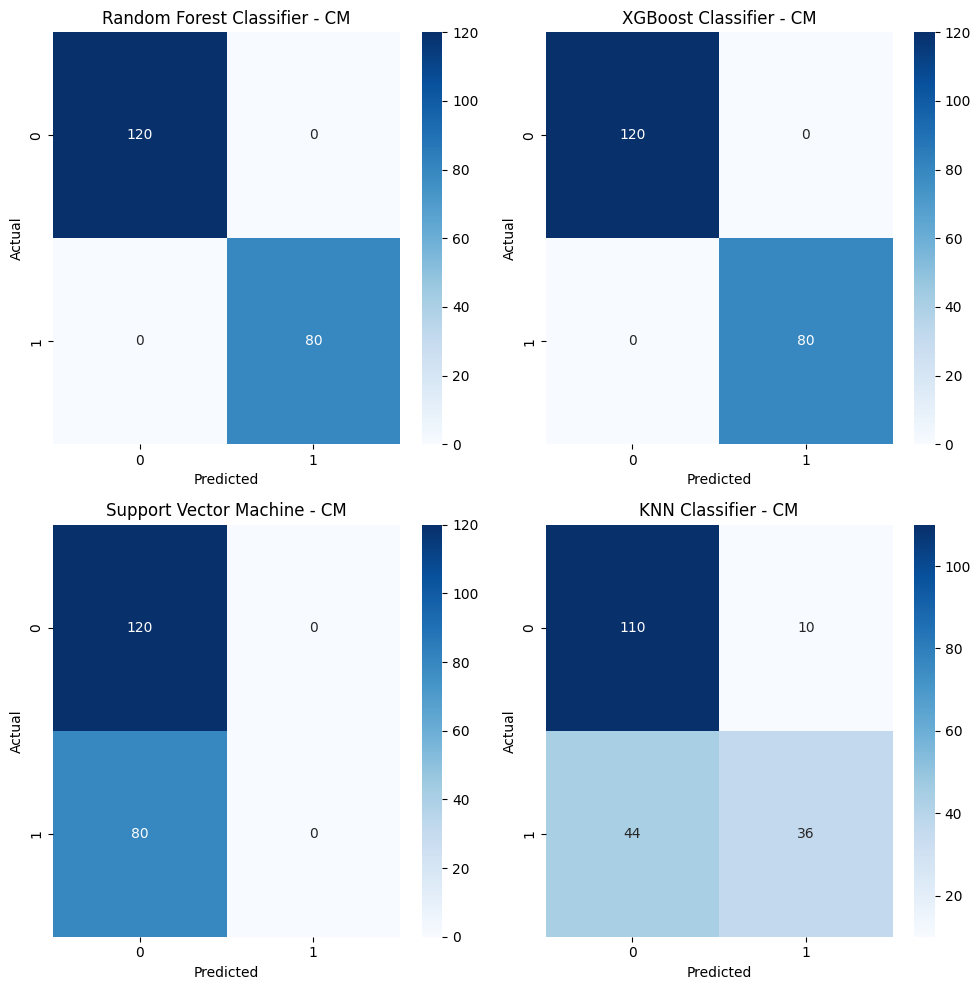

In [17]:
cm1 = confusion_matrix(y_test, P_rfc)
cm2 = confusion_matrix(y_test, P_xgb)
cm3 = confusion_matrix(y_test, P_svc)
cm4 = confusion_matrix(y_test, P_knn)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Classifier - CM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 2, 2)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Classifier - CM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 2, 3)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues')
plt.title('Support Vector Machine - CM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(2, 2, 4)
sns.heatmap(cm4, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Classifier - CM')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()


In [18]:
# save the model to disk
filename = 'weights/donation-2023/xgb.sav'
pickle.dump(rfc, open(filename, 'wb'))

In [19]:
sample_json = {
                "Age": 60,
                "Blood type": "AB-",
                "Gender": "F",
                "Height (M)": 1.76,
                "Weight": 60,
                "BMI": 19.36983471,
                "Blood camp held date": "10/14/2020",
                "BMI Y/N": 1,
                "Last donated date": "3/2/2018",
                "Doner Province": "Uva",
                "Camp held provinces": "Western",
                "DonateBloodTill2023": 1
                }


def inference(
            sample_json,
            cat_cols = ['Blood type', 'Gender', 'Doner Province', 'Camp held provinces'],
            label_encoder_path = 'weights/donation-2023/label_encoder.pkl'
            ):
    sample = pd.DataFrame(sample_json, index=[0])
    del sample['Blood camp held date']
    del sample['Last donated date']

    columns = sample.columns.values
    sample.columns = [col.strip() for col in columns]
    for col in sample.columns:
        sample[col] = sample[col].astype(str).str.strip()

    # Load label encoder
    with open(label_encoder_path, 'rb') as f:
        d = pickle.load(f)

    for col in cat_cols:
        sample[col] = d[col].transform(sample[col])
        
    for col in sample.columns:
        sample[col] = sample[col].astype(float)

    with open('weights/donation-2023/scaler.pkl', 'rb') as f:
        scaler = pickle.load(f)

    sample = scaler.transform(sample)
    pred = int(rfc.predict(sample).squeeze())
    return pred

In [20]:
inference(sample_json)

c:\Users\Tharushi\.conda\envs\myenv\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


1